In [1]:
conda env list

# conda environments:
#
NewEnv                   /home/achartra/.conda/envs/NewEnv
PINNICLEenv           *  /home/achartra/.conda/envs/PINNICLEenv
allison                  /home/achartra/.conda/envs/allison
baseclone                /home/achartra/.conda/envs/baseclone
base                     /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05
earthml                  /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/earthml
esmvaltool               /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/esmvaltool
gdalNgmt                 /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/gdalNgmt
ilab-pytorch             /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/ilab-pytorch
ilab-tensorflow          /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/ilab-tensorflow
ml                       /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhe

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-12-20 09:32:44.084065: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 09:32:45.516221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734705165.771418  993479 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734705165.846337  993479 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 09:32:46.826234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [2]:
# Testing PINNICLE
# Infer basal friction coefficients using SSA

import pinnicle as pinn
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from datetime import datetime

# Set up some configurations
dde.config.set_default_float('float64')
dde.config.disable_xla_jit()
dde.config.set_random_seed(1234)


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.

Disable just-in-time compilation with XLA.


Set the default float type to float64


In [3]:
# Load the correct data

issm_filename = "Ryder_test_I19-Dec-2024_3"
datestr = datetime.now().strftime("%d-%b-%y")

issm_pinn_path = issm_filename + "_P" + datestr + "_1"
# General parameters for training
# Setting up dictionaries
# order doesn't matter, but keys DO matter
hp = {}

# Load data ? 
# In data_size, each key:value pair defines a variable in the training. 
# if the key is not redefined in name_map, then it will be used as default 
# or set in the physics section above. The value associated with the key 
# gives the number of data points used for training.
# If the value is set to None, then only Dirichlet BC around the domain 
# boundary will be used for the corresponding key. If the variable is included
# in the training, but not given in data_size, then there will be no data for this variable in the training
flightTrack = {}
flightTrack["data_path"] = "./Ryder_xyz.mat"
flightTrack["data_size"] = {"H": 80000}
flightTrack["name_map"] = {"H": "thickness"}
flightTrack["X_map"] = {"x": "x", "y":"y"}
flightTrack["source"] = "mat"
hp["data"] = {"ft": flightTrack}

issm = {}
issm["data_path"] = "./Models/" + issm_filename + ".mat"
issm["data_size"] = {"u":10000, "v":10000, "s":10000, "H":None, "C":10000, "vel":10000}
hp["data"] = {"ISSM":issm, "ft":flightTrack} # hp = 'hyperparameters'

hp["epochs"] = int(5e4)
hp["learning_rate"] = 0.0005
hp["loss_function"] = "MSE"
hp["save_path"] = "./PINNs/" + issm_pinn_path
hp["is_save"] = True
hp["is_plot"] = True

# Set NN architecture
hp["activation"] = "tanh"
hp["initializer"] = "Glorot uniform"
hp["num_neurons"] = 20
hp["num_layers"] = 6
hp["input"] = ['y', 'x']

# Define domain of computation
hp["shapefile"] = "./Ryder_32_09.exp"
# Define number of collocation points used to evaluate PDE residual
hp["num_collocation_points"] = 20000

# Add physics
yts = pinn.physics.Constants().yts
SSA = {}
SSA["scalar_variables"] = {"B":2e+08, "n":3} # -20 deg C
                    # u                     v                 s        H      C
SSA["data_weights"] = [(1.0e-2*yts)**2.0, (1.0e-2*yts)**2.0, 5.0e-6, 5.0e-6, 5.0e-8]
# hp["equations"] = {"SSA":{"input":["x1", "x2"]}}
hp["equations"] = {"SSA":SSA}

# MOLHO = {}
# MOLHO["scalar_variables"] = {"B":2e+08}
# hp["equations"] = {"MOLHO":MOLHO}
#                     #        u                 v                u_base               v_base            s        H      C
# MOLHO["data_weights"] = [(1.0e-2*yts)**2.0, (1.0e-2*yts)**2.0, (1.0e-2*yts)**2.0, (1.0e-2*yts)**2.0, 1.0e-6, 1.0e-6, 1.0e-8]

hp['fft'] = True
hp['sigma'] = 5
hp['num_fourier_feature'] = 30

# Add an additional loss function to balance the contributions between the fast flow and slow moving regions:
# vel_loss = {}
# vel_loss['name'] = "vel log"
# vel_loss['function'] = "VEL_LOG"
# vel_loss['weight'] = 1.0e-5
# hp["additional_loss"] = {"vel":vel_loss}

experiment = pinn.PINN(hp) # set up class PINN (in pinn.py in pinnicle package)
# experiment.update_parameters(hp)
print(experiment.params) # make sure that settings are in correct spot (keys must be correct)

ERROR:root:ERROR: MATLAB type not supported: qmustatistics, (uint32)
ERROR:root:ERROR: MATLAB type not supported: lovenumbers, (uint32)
ERROR:root:ERROR: MATLAB type not supported: rotational, (uint32)
ERROR:root:ERROR: MATLAB type not supported: solidearthsettings, (uint32)


add Fourier feature transform to input transform
add output transform with [-3.1709792e-04 -3.1709792e-04 -1.0000000e+03  1.0000000e+01
  1.0000000e-02] and [3.1709792e-04 3.1709792e-04 3.6000000e+03 3.5000000e+03 1.0000000e+04]
Parameters: 
	TrainingParameter: 
		epochs:	50000
		optimizer:	adam
		loss_functions:	['MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE']
		additional_loss:	{}
		learning_rate:	0.0005
		loss_weights:	[1e-10, 1e-10, 99451929600.0, 99451929600.0, 5e-06, 5e-06, 5e-08]
		has_callbacks:	False
		min_delta:	None
		patience:	None
		period:	None
		checkpoint:	False
		save_path:	./PINNs/Ryder_test_I19-Dec-2024_3_P20-Dec-24_1
		is_save:	True
		is_plot:	True
	DomainParameter: 
		shapefile:	./Ryder_32_09.exp
		num_collocation_points:	20000
		time_dependent:	False
		start_time:	0
		end_time:	0
	DataParameter: 
		ISSM:
			data_path:	./Models/Ryder_test_I19-Dec-2024_3.mat
			data_size:	{'u': 10000, 'v': 10000, 's': 10000, 'H': None, 'C': 10000, 'vel': 10000}
			name_map:	{'u': '

2024-12-20 09:35:11.847702: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1734705311.847941  993479 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


Compiling model...
'compile' took 0.007290 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [2.71e+02, 2.69e+02, 8.46e+02, 1.20e+03, 1.41e+01, 1.82e+00, 2.00e-01]    [2.71e+02, 2.69e+02, 8.46e+02, 1.20e+03, 1.41e+01, 1.82e+00, 2.00e-01]    []  
10000     [8.77e-02, 1.55e-02, 1.43e-02, 8.30e-03, 4.51e-03, 6.52e-02, 1.99e-02]    [8.77e-02, 1.55e-02, 1.43e-02, 8.30e-03, 4.51e-03, 6.52e-02, 1.99e-02]    []  
20000     [1.34e-03, 2.37e-03, 1.37e-03, 3.71e-03, 4.07e-04, 3.46e-02, 4.80e-03]    [1.34e-03, 2.37e-03, 1.37e-03, 3.71e-03, 4.07e-04, 3.46e-02, 4.80e-03]    []  
30000     [3.89e-03, 2.00e-03, 6.20e-04, 5.98e-04, 3.39e-04, 2.75e-02, 3.54e-03]    [3.89e-03, 2.00e-03, 6.20e-04, 5.98e-04, 3.39e-04, 2.75e-02, 3.54e-03]    []  
40000     [2.02e-03, 1.03e-03, 5.00e-04, 6.32e-04, 3.74e-04, 2.42e-02, 3.69e-03]    [2.02e-03, 1.03e-03, 5.00e-04

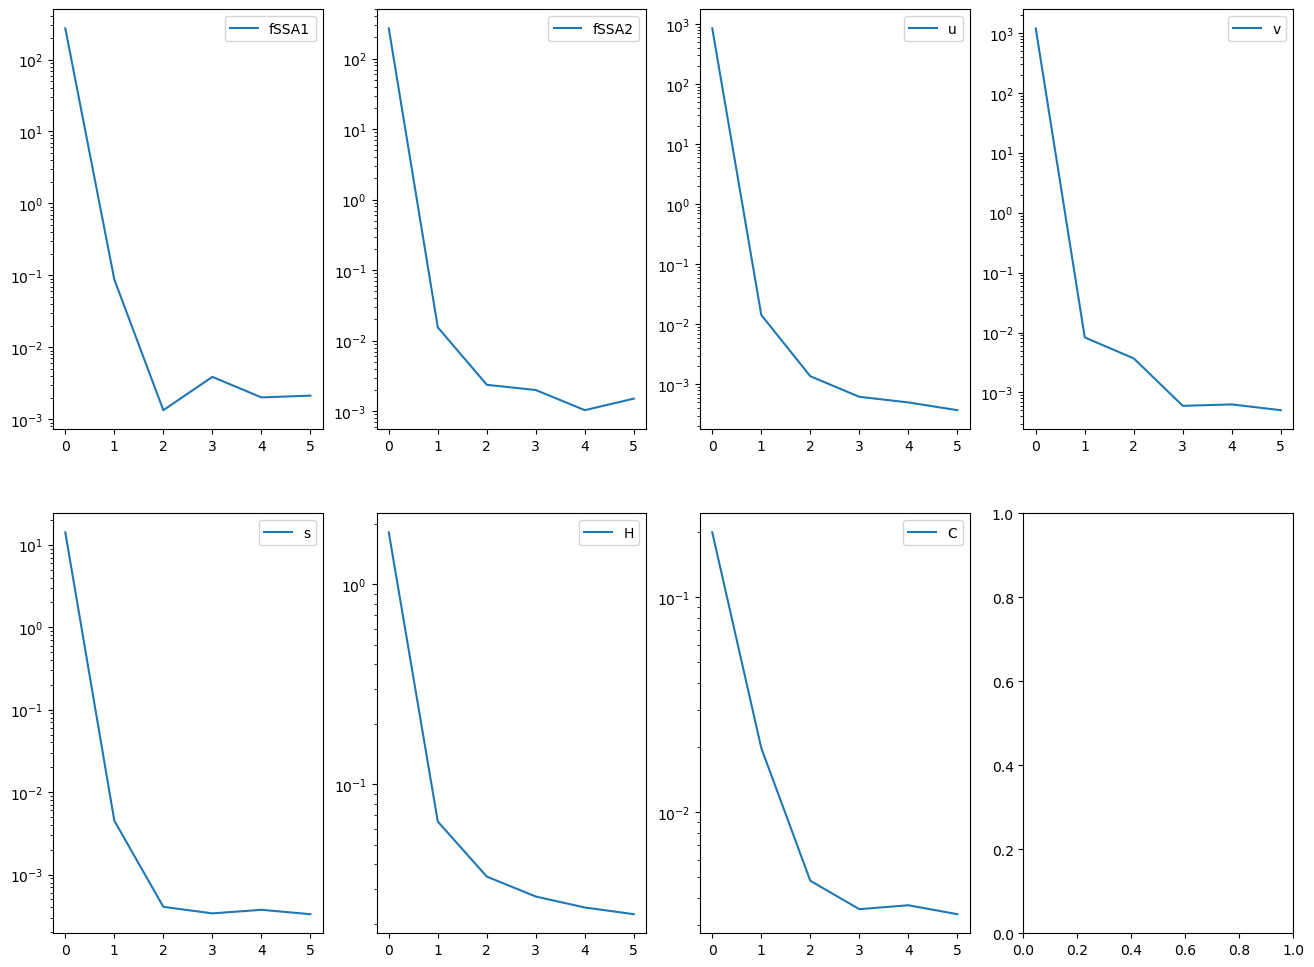

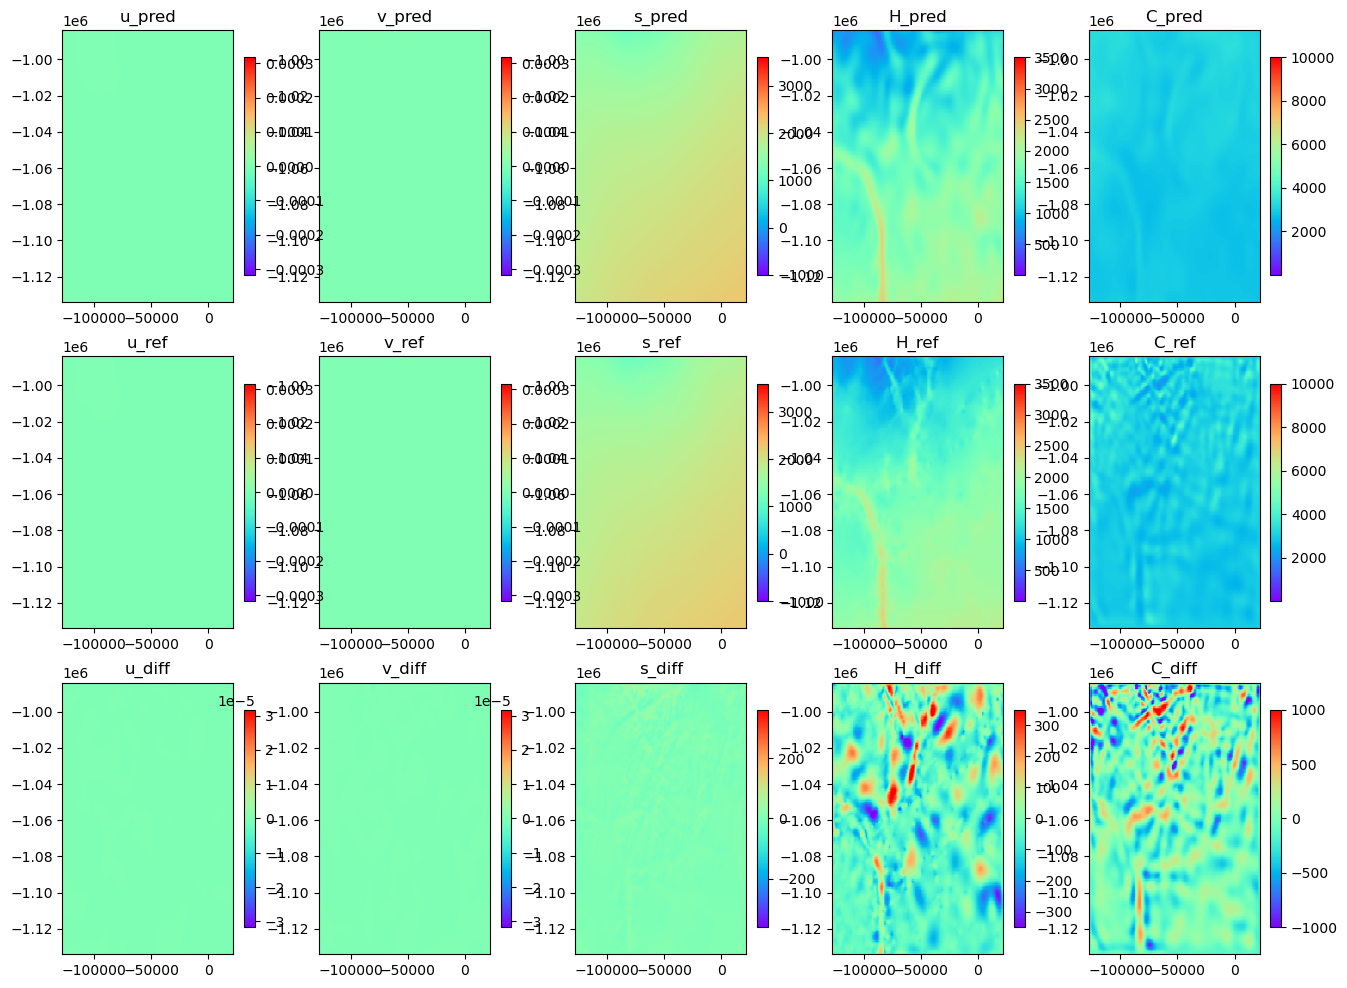

In [4]:
# Now run the PINN model
experiment.compile()

# Train
experiment.train()
# Show results
experiment.plot_predictions(X_ref=experiment.model_data.data["ISSM"].X_dict, sol_ref=experiment.model_data.data["ISSM"].data_dict)

# Save results 
import hdf5storage
import scipy


resolution = 200
    # generate 200x200 mesh on the domain
X, Y = np.meshgrid(np.linspace(experiment.params.nn.input_lb[0], experiment.params.nn.input_ub[0], resolution),
                   np.linspace(experiment.params.nn.input_lb[1], experiment.params.nn.input_ub[1], resolution))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

# predicted solutions
sol_pred = experiment.model.predict(X_nn)
plot_data = {k+"_pred":np.reshape(sol_pred[:,i:i+1], X.shape) for i,k in enumerate(experiment.params.nn.output_variables)}

mat_data = {} # make a dictionary to store the MAT data in
vars2save = ['sol_pred','X_nn']
for i, var_curr in enumerate(vars2save):
    exec(f'mat_data[u"{var_curr}"] = {var_curr}')
 
hdf5storage.savemat(hp["save_path"] + '/' + issm_pinn_path + '_predictions.mat', mat_data, format='7.3', oned_as='row', store_python_metadata=True)

In [66]:
# print(len(experiment.model_data.X['C']))
# print(len(experiment.model_data.X['H']))
# print(experiment.model_data.sol)
# print(experiment.params.param_dict['B'])
print(vars(experiment.params.physics))

{'param_dict': {'data': {'ISSM': {'data_path': './Models/Ryder_test_I05-Dec-2024_2.mat', 'data_size': {'u': 5000, 'v': 5000, 's': 5000, 'H': None, 'C': 5000, 'vel': 5000}}, 'ft': {'data_path': './Ryder_xyz.mat', 'data_size': {'H': 8000}, 'name_map': {'H': 'thickness'}, 'X_map': {'x': 'x', 'y': 'y'}, 'source': 'mat'}}, 'epochs': 100000, 'learning_rate': 0.0005, 'loss_function': 'MSE', 'save_path': './PINNs/Ryder_test_I05-Dec-2024_2_P16-Dec-24_2', 'is_save': True, 'is_plot': True, 'activation': 'tanh', 'initializer': 'Glorot uniform', 'num_neurons': 20, 'num_layers': 6, 'input': ['y', 'x'], 'shapefile': './Ryder_32_09.exp', 'num_collocation_points': 10000, 'equations': {'SSA': {'scalar_variables': {'B': 200000000.0, 'n': 4}, 'data_weights': [99451929600.0, 99451929600.0, 5e-06, 1e-06, 1e-08]}}, 'fft': True, 'sigma': 5, 'num_fourier_feature': 30, 'B': [[6.605542387359734, 1.1229533305596202, 7.43116665398821, -3.535552712628588, 1.424607792835342, -0.7693938490405215, 2.957133272478977, -

**Below this is old and unpolished code for playing around**

In [4]:
# How to print different sections of model
# print(experiment.params.training)

# print(experiment.params.nn.output_lb)
# print(experiment.model.predict)

import deepxde.backend as bkd

resolution = 200
    # generate 200x200 mesh on the domain
X, Y = np.meshgrid(np.linspace(experiment.params.nn.input_lb[0], experiment.params.nn.input_ub[0], resolution),
                   np.linspace(experiment.params.nn.input_lb[1], experiment.params.nn.input_ub[1], resolution))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
grid_size = 2.0*(((experiment.params.nn.input_ub[0] - experiment.params.nn.input_lb[0])/resolution)**2+
                 ((experiment.params.nn.input_ub[1] - experiment.params.nn.input_lb[1])/resolution)**2)**0.5
if bkd.backend_name == "pytorch":
    grid_size = bkd.to_numpy(grid_size)

# predicted solutions
sol_pred = experiment.model.predict(X_nn)
plot_data = {k+"_pred":np.reshape(sol_pred[:,i:i+1], X.shape) for i,k in enumerate(experiment.params.nn.output_variables)}


[-3.1709792e-04 -3.1709792e-04 -1.0000000e+03  1.0000000e+01
  1.0000000e-02]
<bound method Model.predict of <deepxde.model.Model object at 0x1504e5075630>>


In [5]:
import hdf5storage
import scipy
 
mat_data = {} # make a dictionary to store the MAT data in
vars2save = ['sol_pred','X_nn']
for i, var_curr in enumerate(vars2save):
    exec(f'mat_data[u"{var_curr}"] = {var_curr}')
 
hdf5storage.savemat(hp["save_path"] + '/' + issm_pinn_path + '_predictions.mat', mat_data, format='7.3', oned_as='row', store_python_metadata=True)

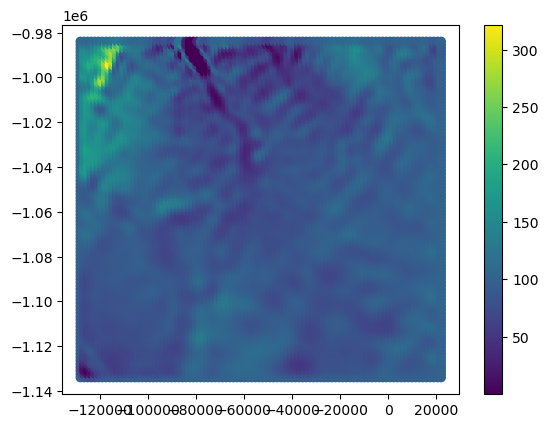

In [4]:
# Plotting attempts

# Show results
# experiment.plot_predictions(X_ref=experiment.model_data.data["ISSM"].X_dict, sol_ref=experiment.model_data.data["ISSM"].data_dict)

# pinn.utils.plotting.plot_data(experiment.model_data.data["ISSM"].X_dict['x'],experiment.model_data.data["ISSM"].X_dict['y'], experiment.model_data.data["ISSM"].data_dict['u'])

plt.scatter(experiment.model_data.data["ISSM"].X_dict['x'], experiment.model_data.data["ISSM"].X_dict['y'], c=experiment.model_data.data["ISSM"].data_dict['C'], cmap='viridis')
plt.colorbar()